**Implementacija jednostavnog chatbota koristeći MLP NN**

Ovaj notebook predstavlja osnovni set koraka za implementaciju jednostavnog chatbota na bazi dubokog i/ili mašinskog učenja koristeći Multi-level perceprton neuronsku mrežu (Sequential model).

Osnovni importi

In [ ]:
%pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import string
import random
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer 
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Učitavanje podataka

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

f = open('/content/drive/My Drive/BasicNNChatbot/intents.json',)

data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pretprocesiranje podataka

In [ ]:
# initializing lemmatizer to get stem of words

lemmatizer = WordNetLemmatizer()# Each list to create
words = []
classes = []
doc_X = []
doc_y = []# Loop through all the intents


# tokenize each pattern and append tokens to words, the patterns and
# the associated tag to their associated listfor intent in data["intents"]:
for intent in data["intents"]:
  for pattern in intent["patterns"]:
      tokens = nltk.word_tokenize(pattern)
      words.extend(tokens)
      doc_X.append(pattern)
      doc_y.append(intent["tag"])

  # add the tag to the classes if it's not there already 
  if intent["tag"] not in classes:
      classes.append(intent["tag"])# lemmatize all the words in the vocab and convert them to lowercase


# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]# sorting the vocab and classes in alphabetical order and taking the # set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))

Ispis rezultata pretprocesiranja

In [ ]:
print(words)
print('------------------------------------------------------------------------------------')
print(classes)
print('------------------------------------------------------------------------------------')
print(doc_X)
print('------------------------------------------------------------------------------------')
print(doc_y)
print('------------------------------------------------------------------------------------')

["'s", 'adios', 'are', 'birthday', 'born', 'bye', 'called', 'cao', 'cya', 'do', 'doing', 'for', 'g2g', 'hang', 'hello', 'hi', 'how', 'is', 'name', 'old', 'out', 'plan', 'see', 'some', 'there', 'this', 'time', 'to', 'up', 'want', 'week', 'weekend', 'were', 'what', 'whats', 'when', 'who', 'ya', 'you', 'your']
------------------------------------------------------------------------------------
['age', 'date', 'goodbye', 'greeting', 'name']
------------------------------------------------------------------------------------
['Hello', 'How are you?', 'Hi there', 'Hi', 'Whats up', 'Cao', 'How old are you?', 'When is your birthday?', 'When were you born?', 'what are you doing this weekend?', 'do you want to hang out some time?', 'what are your plans for this week', "what's your name?", 'what are you called?', 'who are you?', 'bye', 'g2g', 'see ya', 'adios', 'cya']
------------------------------------------------------------------------------------
['greeting', 'greeting', 'greeting', 'greetin

Priprema trening podataka

In [ ]:
# list for training data
training = []
out_empty = [0] * len(classes)# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)    # mark the index of class that the current pattern is associated
    # to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1    # add the one hot encoded BoW and associated classes to training 
    training.append([bow, output_row])# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

Model

In [ ]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200

# the deep learning model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])
print(model.summary())
history = model.fit(x=train_X, y=train_y, epochs=200, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               5248      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 13,829
Trainable params: 13,829
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
1/1 [============================

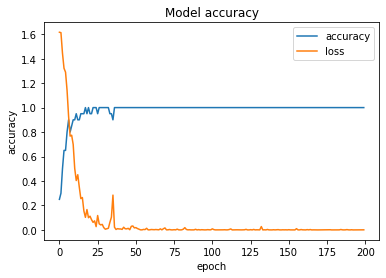

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.show()

Nakon formiranja modela za chatbot, prelazimo na kreiranje pomoćnih funkcija za osnovnu implementaciju chatbota:

In [ ]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

Za pokretanje chatbota, koristit ćemo beskonačnu petlju:

In [ ]:
# running the chatbot
while True:
    print("YOU: ")
    message = input("")
    intents = pred_class(message, words, classes)
    result = get_response(intents, data)
    print("LAKI: ")
    print(result)

YOU: 
Cao
LAKI: 
Pa gdje si ti
YOU: 
what are you doing this weekend?
LAKI: 
Ne mogu, radim DAP projekat
YOU: 
bye
LAKI: 
See you later
YOU: 


KeyboardInterrupt: ignored